In [1]:
import os
import glob
import mne
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

In [2]:
# Standard channel sets
CHANNELS_64 = None  # use all
CHANNELS_38 = list(range(38))
CHANNELS_19 = ["Fp1","Fp2","F3","F4","C3","C4","P3","P4","O1","O2",
                "F7","F8","T3","T4","T5","T6","Fz","Cz","Pz"]
CHANNELS_8 = ["F3","F4","C3","C4","Cz","P3","P4","Pz"]

def pick_channels(raw, n_channels=64):
    if n_channels == 64 or n_channels is None:
        return raw
    elif n_channels == 38:
        return raw.copy().pick_channels([raw.ch_names[i] for i in CHANNELS_38])
    elif n_channels == 19:
        return raw.copy().pick_channels(CHANNELS_19)
    elif n_channels == 8:
        return raw.copy().pick_channels(CHANNELS_8)


In [3]:
def process_file(file_path, T=4, n_channels=64, ds=1):
    """
    Processes one EDF file: filtering, referencing, epoching, removing T0, normalization
    """
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    # Bandpass filter 4-40 Hz
    raw.filter(4., 40., fir_design='firwin')
    
    # Common average reference
    raw.set_eeg_reference("average")
    
    # Channel selection
    raw = pick_channels(raw, n_channels)
    
    # Convert annotations to events
    event_id = {'T0':0, 'T1':1, 'T2':2}
    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    
    # Epoching
    epochs = mne.Epochs(
        raw, events, event_id=event_id,
        tmin=0, tmax=T,
        baseline=None,
        preload=True
    )
    
    X = epochs.get_data()  # shape: trials × channels × samples
    y = epochs.events[:, -1]  # labels
    
    # Remove T0 (idle) for left vs right classification
    mask = y != 0
    X = X[mask]
    y = y[mask]
    y = y - 1  # relabel: T1 -> 0, T2 -> 1
    
    # Downsampling
    if ds > 1:
        X = X[:, :, ::ds]
    
    # Normalize per trial
    for i in range(len(X)):
        X[i] = (X[i] - X[i].mean(axis=-1, keepdims=True)) / (X[i].std(axis=-1, keepdims=True)+1e-6)
    
    return X, y


In [4]:
def get_subject_id(path):
    filename = os.path.basename(path)
    m = re.match(r"(S\d+)", filename)
    if m:
        return m.group(1)
    else:
        raise ValueError(f"Could not extract subject id from {path}")

In [5]:
all_files = glob.glob("../data/full_data/S*/S*R*.edf")
#all_files = all_files[:60]  # limit to first 30 files for quicker testing
print(f"Found {len(all_files)} EDF files")

X_list, y_list, subj_list = [], [], []
target_T = None
skipped_files = 0


Found 327 EDF files


In [6]:
for f in all_files:
    subject_id = get_subject_id(f)
    #print(subject_id)
    X, y = process_file(f, T=4, n_channels=64, ds=1)
    
    n_times = X.shape[-1]
    if target_T is None:
        target_T = n_times
        print(f"Set target_T = {target_T} from file {f}")
    else:
        if n_times > target_T:
            X = X[..., :target_T]
        elif n_times < target_T:
            skipped_files += 1
            print(f"Skipping file {f} because n_times={n_times} < target_T={target_T}")
            continue
    X_list.append(X)
    y_list.append(y)
    subj_list.append(np.array([subject_id] * len(y), dtype=object))
X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
subj_all = np.concatenate(subj_list, axis=0)

print("Final shape:", X_all.shape, y_all.shape, subj_all.shape)
print(f"Skipped {skipped_files} files")





Extracting EDF parameters from /home/niklas/Dokumente/AdvML/aml/EEG_MotorImagery_Project/data/full_data/S109/S109R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (1.656 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.

/tmp/ipykernel_38476/769691618.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
/tmp/ipykernel_38476/769691618.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
/tmp/ipykernel_38476/769691618.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/niklas/Dokumente/AdvML/aml/EEG_MotorImagery_Project/data/full_data/S094/S094R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (1.656 s)

EEG channel type s

In [7]:
for i in range(len(X_list)):

    print(f" Subject: {(i//3)+1} File {i}: X shape: {X_list[i].shape}, y shape: {y_list[i].shape}")

 Subject: 1 File 0: X shape: (15, 64, 641), y shape: (15,)
 Subject: 1 File 1: X shape: (15, 64, 641), y shape: (15,)
 Subject: 1 File 2: X shape: (15, 64, 641), y shape: (15,)
 Subject: 2 File 3: X shape: (15, 64, 641), y shape: (15,)
 Subject: 2 File 4: X shape: (15, 64, 641), y shape: (15,)
 Subject: 2 File 5: X shape: (15, 64, 641), y shape: (15,)
 Subject: 3 File 6: X shape: (15, 64, 641), y shape: (15,)
 Subject: 3 File 7: X shape: (15, 64, 641), y shape: (15,)
 Subject: 3 File 8: X shape: (15, 64, 641), y shape: (15,)
 Subject: 4 File 9: X shape: (14, 64, 641), y shape: (14,)
 Subject: 4 File 10: X shape: (14, 64, 641), y shape: (14,)
 Subject: 4 File 11: X shape: (15, 64, 641), y shape: (15,)
 Subject: 5 File 12: X shape: (15, 64, 641), y shape: (15,)
 Subject: 5 File 13: X shape: (15, 64, 641), y shape: (15,)
 Subject: 5 File 14: X shape: (15, 64, 641), y shape: (15,)
 Subject: 6 File 15: X shape: (15, 64, 641), y shape: (15,)
 Subject: 6 File 16: X shape: (15, 64, 641), y sha

In [8]:
X_tensor = torch.tensor(X_all, dtype=torch.float32).unsqueeze(1)  # (trials, 1, C, T)
y_tensor = torch.tensor(y_all, dtype=torch.long)

print(X_tensor.shape)  # should be (N, 1, 64, 640)


torch.Size([4748, 1, 64, 641])


In [9]:
#print(np.unique(train_y), np.unique(val_y))
#print(np.count_nonzero(train_y), np.count_nonzero(val_y))

In [10]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
num_samples = X_tensor.shape[0]
indices = torch.randperm(num_samples)

train_end = int(0.7*num_samples)
val_end   = int(0.85*num_samples)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

train_X, train_y = X_tensor[train_idx], y_tensor[train_idx]
val_X, val_y     = X_tensor[val_idx], y_tensor[val_idx]
test_X, test_y   = X_tensor[test_idx], y_tensor[test_idx]


train_dataset = EEGDataset(train_X, train_y)
val_dataset   = EEGDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)    #CHANGE HERE
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [11]:
y_tensor

tensor([1, 0, 1,  ..., 1, 0, 0])

In [12]:
class EEGNet(nn.Module):
    def __init__(self, in_chans=64, n_classes=2, input_time=640, dropout=0.5):   
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 64), padding=(0,32), bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (in_chans,1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d((1,4)),
            nn.Dropout(dropout)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1,16), padding=(0,8), groups=32, bias=False),
            nn.Conv2d(32, 32, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d((1,8)),
            nn.Dropout(dropout)
        )
        # Compute flatten size dynamically
        self.flatten_size = self._get_flatten_size(input_time)
        self.classifier = nn.Linear(self.flatten_size, n_classes)
        
    def _get_flatten_size(self, input_time):
        x = torch.zeros(1,1,64,input_time)
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        return x.view(1,-1).shape[1]
    
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EEGNet(in_chans=64, n_classes=2, input_time=X_tensor.shape[-1], dropout=0.5).to(device)       #CHANGE HERE

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)                                    #CHANGE HERE

epochs = 20

# ======== Initialize lists to store metrics ========
train_losses = []
trainEEG_accuracies = []
val_losses = []
valEEG_accuracies = []
y_true = []
y_pred = []

for epoch in range(epochs):
    # ======== Training ========
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    trainEEG_accuracies.append(train_acc)
    
    # ======== Validation ========
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

            if epoch == epochs -1:
                y_true.extend(y_batch.numpy())
                y_pred.extend(preds.numpy())
                
            
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    valEEG_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1/20: Train Loss=0.7196, Train Acc=0.4896, Val Loss=0.6924, Val Acc=0.5098
Epoch 2/20: Train Loss=0.7021, Train Acc=0.5164, Val Loss=0.6875, Val Acc=0.5660
Epoch 3/20: Train Loss=0.6948, Train Acc=0.5260, Val Loss=0.6888, Val Acc=0.5084
Epoch 4/20: Train Loss=0.6850, Train Acc=0.5408, Val Loss=0.6737, Val Acc=0.6039
Epoch 5/20: Train Loss=0.6694, Train Acc=0.5832, Val Loss=0.6491, Val Acc=0.6180
Epoch 6/20: Train Loss=0.6417, Train Acc=0.6277, Val Loss=0.6193, Val Acc=0.6587
Epoch 7/20: Train Loss=0.6064, Train Acc=0.6666, Val Loss=0.5801, Val Acc=0.7037
Epoch 8/20: Train Loss=0.5810, Train Acc=0.6888, Val Loss=0.5815, Val Acc=0.7008
Epoch 9/20: Train Loss=0.5576, Train Acc=0.7042, Val Loss=0.5489, Val Acc=0.7051
Epoch 10/20: Train Loss=0.5439, Train Acc=0.7222, Val Loss=0.5188, Val Acc=0.7416
Epoch 11/20: Train Loss=0.5265, Train Acc=0.7346, Val Loss=0.5120, Val Acc=0.7514
Epoch 12/20: Train Loss=0.5034, Train Acc=0.7511, Val Loss=0.4907, Val Acc=0.7584
Epoch 13/20: Train Loss=0

[[0.86478873 0.13521127]
 [0.25210084 0.74789916]]


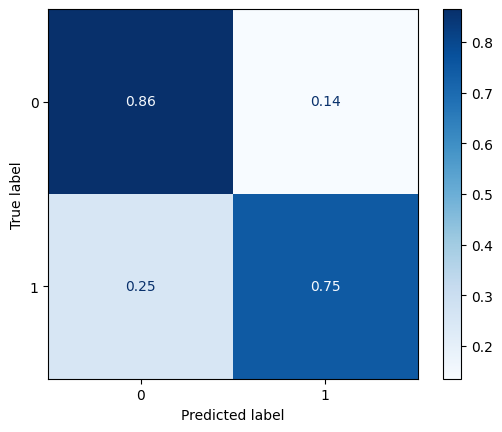

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ======== Loss Curve ========
#plt.figure(figsize=(10,4))
#plt.plot(train_losses, label='Train Loss')
#plt.plot(val_losses, label='Validation Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss')
#plt.legend()
#plt.show()

# ======== Accuracy Curve ========
#plt.figure(figsize=(10,4))
#plt.plot(train_accuracies, label='Train Accuracy')
#plt.plot(val_accuracies, label='Validation Accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.title('Training and Validation Accuracy')
#plt.legend()
#plt.show()

# ======== Confusion Matrix ======
cm = confusion_matrix(y_true, y_pred, normalize ='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
class Square(nn.Module):
    """x -> x^2"""
    def forward(self, x):
        return x ** 2

class SafeLog(nn.Module):
    """x -> log(x) with numerical stabilisation"""
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        return torch.log(torch.clamp(x, min=self.eps))

# Shallow ConvNet Model
class ShallowConvNet(nn.Module):
    def __init__(self, n_classes: int, n_channels: int = 64, input_time_samples: int = 640, dropout=0.5):
        """
        Parameters
        ----------
        n_classes : int
            Number of output classes.
        n_channels : int
            Number of electrodes
        input_time_samples : int
            Number of input time samples (e.g. 640 for 4 s @ 160 Hz).
        """
        super(ShallowConvNet, self).__init__()
        
        # Hyperparameters
        self.n_filters = 40
        self.n_channels = n_channels
        
        # Layers
        # Input time x electrodes (paper 534x44, we _x64)
        self.temporal_conv = nn.Conv2d(
            in_channels=1,
            out_channels=self.n_filters,
            kernel_size=(1, 16), # paper used 25 for sample rate 250 -> we use 16 for sample rate 160?
            bias=False
        ) # 40 Units temporal conv
        
        self.spatial_filter = nn.Conv2d(
            in_channels=self.n_filters,
            out_channels=self.n_filters,
            kernel_size=(self.n_channels, 1),
            groups=self.n_filters,
            bias=False # arl disables bias
        ) # 40 Units spatial filter (conv)
        
        self.bn = nn.BatchNorm2d(self.n_filters)
        
        self.square = Square() # Squaring Non-linearity
        self.mean_pooling = nn.AvgPool2d(kernel_size=(1, 48), stride=(1, 9)) # 75x1 kernel Mean Pooling w. 15 x 1 stride -> 48, 1 and 9, 1 (or 10, 1?). Only AvgPooling available.
        self.log_activation = SafeLog() # Log activation
        
        # Arl adds dropout layer
        self.dropout = nn.Dropout(dropout)
        
        n_features = self._get_flatten_size(input_time_samples)
        self.dense = nn.Linear(n_features, n_classes) # Linear classification
        #self.softmax = nn.Softmax(dim=1) # softmax

    def _get_flatten_size(self, input_time):
        with torch.no_grad():
            x = torch.zeros(1, 1, self.n_channels, input_time)
            x = self.temporal_conv(x)
            x = self.spatial_filter(x)
            x = self.mean_pooling(x)
            return x.flatten().shape[0]

    def forward(self, x):
        out = self.temporal_conv(x)
        out = self.spatial_filter(out)
        out = self.bn(out)
        out = self.square(out)
        out = self.mean_pooling(out)
        out = self.log_activation(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        #out = self.softmax(out)
        return out

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [17]:
model = ShallowConvNet(n_channels=64, n_classes=2, input_time_samples=X_tensor.shape[-1], dropout =0.5).to(device) #CHANGE HERE

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)   #CHANGE HERE

epochs = 20

# ======== Initialize lists to store metrics ========
train_losses = []
trainShallow_accuracies = []
val_losses = []
valShallow_accuracies = []
y_true = []
y_pred = []

for epoch in range(epochs):
    # ======== Training ========
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    trainShallow_accuracies.append(train_acc)
    
    # ======== Validation ========
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

            if epoch == epochs -1:
                y_true.extend(y_batch.numpy())
                y_pred.extend(preds.numpy())
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    valShallow_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1/20: Train Loss=0.7144, Train Acc=0.5642, Val Loss=0.6581, Val Acc=0.6096
Epoch 2/20: Train Loss=0.6026, Train Acc=0.6756, Val Loss=0.6010, Val Acc=0.6643
Epoch 3/20: Train Loss=0.5421, Train Acc=0.7295, Val Loss=0.5310, Val Acc=0.7135
Epoch 4/20: Train Loss=0.4997, Train Acc=0.7620, Val Loss=0.5093, Val Acc=0.7430
Epoch 5/20: Train Loss=0.4639, Train Acc=0.7785, Val Loss=0.5124, Val Acc=0.7374
Epoch 6/20: Train Loss=0.4404, Train Acc=0.7990, Val Loss=0.4838, Val Acc=0.7556
Epoch 7/20: Train Loss=0.4136, Train Acc=0.8155, Val Loss=0.5313, Val Acc=0.7500
Epoch 8/20: Train Loss=0.4160, Train Acc=0.8056, Val Loss=0.5057, Val Acc=0.7584
Epoch 9/20: Train Loss=0.3963, Train Acc=0.8276, Val Loss=0.5031, Val Acc=0.7514
Epoch 10/20: Train Loss=0.3654, Train Acc=0.8420, Val Loss=0.4982, Val Acc=0.7584
Epoch 11/20: Train Loss=0.3563, Train Acc=0.8432, Val Loss=0.5199, Val Acc=0.7514
Epoch 12/20: Train Loss=0.3463, Train Acc=0.8459, Val Loss=0.5008, Val Acc=0.7542
Epoch 13/20: Train Loss=0

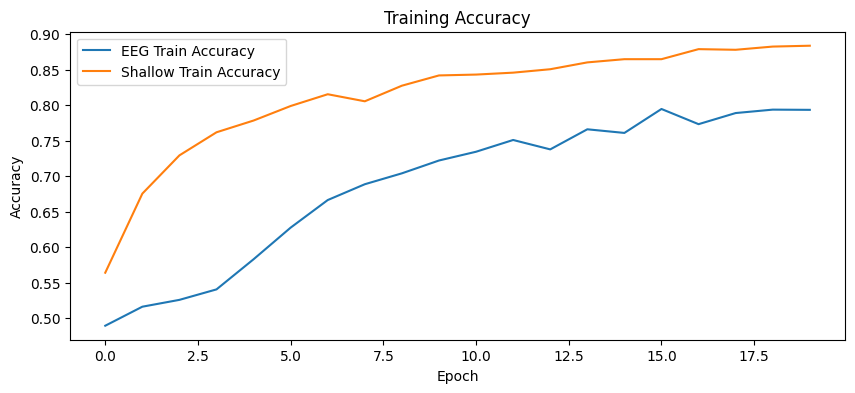

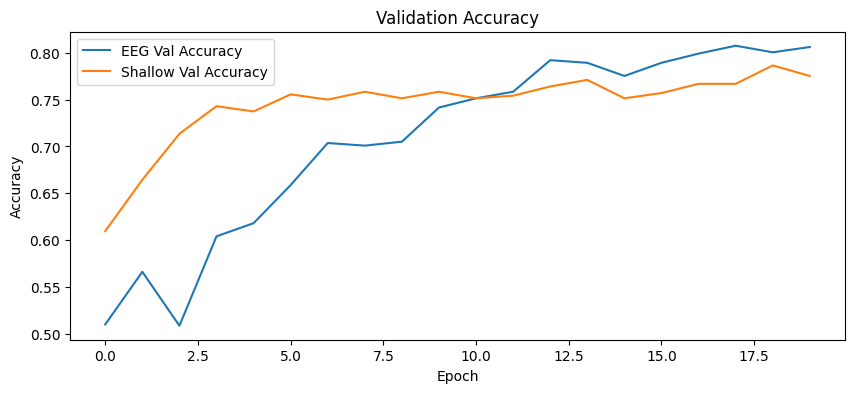

[[0.74929577 0.25070423]
 [0.19887955 0.80112045]]


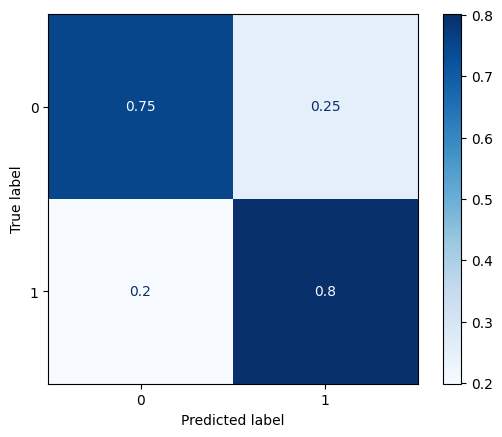

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ======== Loss Curve ========
#plt.figure(figsize=(10,4))
#plt.plot(train_losses, label='Train Loss')
#plt.plot(val_losses, label='Validation Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss')
#plt.legend()
#plt.show()

# ======== Accuracy Curve ========
#plt.figure(figsize=(10,4))
#plt.plot(train_accuracies, label='Train Accuracy')
#plt.plot(val_accuracies, label='Validation Accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.title('Training and Validation Accuracy')
#plt.legend()
#plt.show()

# ======== Comparison Curve ========
plt.figure(figsize=(10,4))
plt.plot(trainEEG_accuracies, label='EEG Train Accuracy')
plt.plot(trainShallow_accuracies, label='Shallow Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(valEEG_accuracies, label='EEG Val Accuracy')
plt.plot(valShallow_accuracies, label='Shallow Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()
# ======== Confusion Matrix ======
cm = confusion_matrix(y_true, y_pred, normalize ='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()